In [ ]:
%%capture
!pip install tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten, TimeDistributed, Reshape, BatchNormalization, Dropout, GlobalAveragePooling2D, MaxPooling3D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
file_path = '/content/drive/My Drive/CarCrash/vgg16_features/positive/000001.npz'
data = np.load(file_path)


In [ ]:
# Function to generate training and testing data split
def generate_train_test_split(test_size=0.3):
    # Generate file names with the respective positive or negative prefixes
    positive_files = [f"positive/{i:06d}.npz" for i in range(1, 1501)]
    negative_files = [f"negative/{i:06d}.npz" for i in range(1501, 3001)]

    # Combine positive and negative files
    all_files = positive_files + negative_files
    labels = [1] * len(positive_files) + [0] * len(negative_files)  # 1 for positive, 0 for negative

    # Split the data into training and testing sets
    train_files, test_files, y_train, y_test = train_test_split(all_files, labels, test_size=test_size, stratify=labels)

    # Return the filenames for training and testing sets
    return train_files, test_files, y_train, y_test

# Function to open a feature file given its name
def open_feature_file(file_name, feature_dir):
    # Construct the full path to the file
    file_path = os.path.join(feature_dir, file_name)

    # Load the file using numpy
    with np.load(file_path, allow_pickle=True) as npz_file:
        # Assuming 'data' is the key for the feature data
        # The loaded data should have shape (50, 20, 4096)
        data = npz_file['data']

        # Reshape the data if necessary. For example, if you're using ConvLSTM2D and treating
        # each 4096 feature vector as a 64x64 image, reshape accordingly.
        # Reshape to (50, 20, 64, 64). This treats each feature set as a separate channel in a 64x64 image.
        data_reshaped = data.reshape(50, 20, 64, 64)

    return data_reshaped


In [ ]:
def generate_small_train_test_split(test_size=0.2):
    # Generate a smaller set of file names for testing purposes
    positive_files = [f"positive/{i:06d}.npz" for i in range(1, 251)]
    negative_files = [f"negative/{i:06d}.npz" for i in range(1501, 1751)]

    # Combine positive and negative files
    all_files = positive_files + negative_files
    labels = [1] * len(positive_files) + [0] * len(negative_files)  # 1 for positive, 0 for negative

    # Split the data into smaller training and testing sets
    train_files, test_files, y_train, y_test = train_test_split(all_files, labels, test_size=test_size, stratify=labels)

    # Return the filenames for training and testing sets
    return train_files, test_files, y_train, y_test



In [ ]:
feature_dir = '/content/drive/My Drive/CarCrash/vgg16_features/'  # Replace with the actual path to your feature files
train_files, test_files, y_train, y_test = generate_small_train_test_split()

# Assuming the feature data has shape (50, 20, 4096) as previously mentioned
# Now, load the actual feature data for training and testing
train_data = np.array([open_feature_file(file_name, feature_dir) for file_name in train_files])
test_data = np.array([open_feature_file(file_name, feature_dir) for file_name in test_files])

# Ensure labels are numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
model = Sequential()

# TimeDistributed layer
model.add(TimeDistributed(Dense(64), input_shape=(50, 20, 64, 64)))
model.add(Dropout(0.5))
# First ConvLSTM2D layer
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',
                     strides=(1, 1), return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same'))

# Second ConvLSTM2D layer
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same',
                     strides=(1, 1), return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same'))

# Third ConvLSTM2D layer
model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same',
                     strides=(1, 1), return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())


# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Output layer
model.add(Dense(units=1, activation='sigmoid'))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00009, verbose=1)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 50, 20, 64, 64)    4160      
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 50, 20, 64, 64)    0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 50, 20, 64, 64)    295168    
                                                                 
 batch_normalization (Batch  (None, 50, 20, 64, 64)    256       
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 50, 10, 32, 64)    0         
 D)                                                              
                                                        

In [ ]:
history = model.fit(
    train_data, y_train,
    batch_size=7,
    validation_split=0.2,
    epochs=15,
    callbacks=[reduce_lr]
)


Epoch 1/15
46/46 [==============================] - 58s 938ms/step - loss: 2.3901 - accuracy: 0.8594 - val_loss: 2.9929 - val_accuracy: 0.4375 - lr: 5.0000e-04
Epoch 2/15
46/46 [==============================] - 39s 853ms/step - loss: 1.8378 - accuracy: 0.9281 - val_loss: 2.2544 - val_accuracy: 0.4375 - lr: 5.0000e-04
Epoch 3/15
46/46 [==============================] - 39s 858ms/step - loss: 1.6024 - accuracy: 0.8938 - val_loss: 3.3692 - val_accuracy: 0.4375 - lr: 5.0000e-04
Epoch 4/15
46/46 [==============================] - ETA: 0s - loss: 1.3010 - accuracy: 0.9281
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
46/46 [==============================] - 39s 853ms/step - loss: 1.3010 - accuracy: 0.9281 - val_loss: 2.9964 - val_accuracy: 0.4375 - lr: 5.0000e-04
Epoch 5/15
46/46 [==============================] - 39s 859ms/step - loss: 1.1124 - accuracy: 0.9406 - val_loss: 2.1204 - val_accuracy: 0.4375 - lr: 1.0000e-04
Epoch 6/15
46/46 [======================

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, y_test)
print(f"Test accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

4/4 [==============================] - 3s 539ms/step - loss: 0.8091 - accuracy: 0.9600
Test accuracy: 0.9599999785423279
Test Loss: 0.8090604543685913


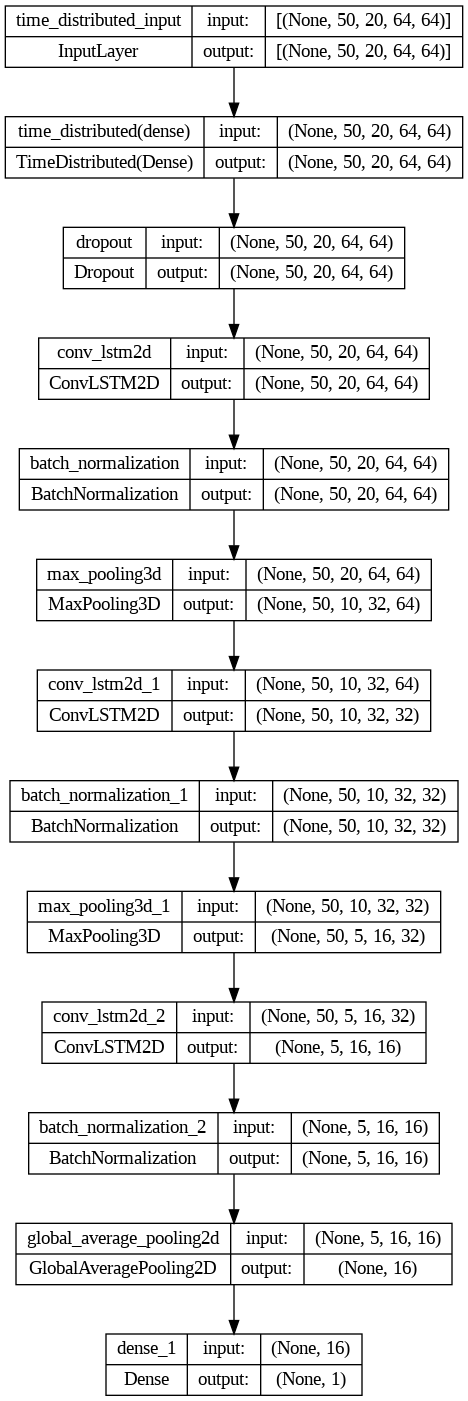

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
